In [83]:
# default_exp vector_to_raster_mask

In [84]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [85]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [86]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo

In [87]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [88]:
# hide
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

# Vector to Raster mask

> convert vectors into rasters where each pixel is a numerical representation of a feature in the vector data

In [89]:
import json
import os

# export
from typing import Dict

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.mask

In [90]:
# exporti
def _get_filepaths(areas, images_dir, pos_mask_dir="", neg_mask_dir=""):
    """
    Returns a dictionary containing the image filepaths for each area.
    Args:
        areas (list) : Python list of strings of the areas of interests (AOIs)
                       e.g. ['maicao', 'riohacha', 'uribia']
    Returns:
        dict : A Python dictionary
    """

    area_dict = {area: dict() for area in areas}

    for area in area_dict:

        area_dict[area]["mask_gpkg"] = "{}{}.gpkg".format(pos_mask_dir, area)

        image_files = []

        for image_file in os.listdir(images_dir):
            if area in image_file:
                image_files.append(images_dir + image_file)

        area_dict[area]["images"] = sorted(image_files)

    return area_dict

In [91]:
# exporti
def _explode(gdf):
    """
    Explodes a geodataframe
    Source: https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
    Will explode muti-part geometries into single geometries.
    Args:
        gdf (gpd.GeoDataFrame) : Input geodataframe with multi-geometries
    Returns:
        gdf (gpd.GeoDataFrame) : Exploded geodataframe with a new index
                                 and two new columns: level_0 and level_1
    """

    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: "geometry"})
    if "class" in gdf2.columns:
        gdf2 = gdf2.drop("class", axis=1)
    gdf_out = gdf2.merge(
        gdf.drop("geometry", axis=1), left_on="level_0", right_index=True
    )
    gdf_out = gdf_out.set_index(["level_0", "level_1"]).set_geometry("geometry")
    gdf_out.crs = gdf.crs

    return gdf_out

In [101]:
# export
GRID_ID = 1


def generate_mask(
    tiff_file,
    shape_file,
    output_file,
    labels_column,
    labels_dict: Dict[str, int],
    plot=False,
):
    """
    Generates a segmentation mask for one TIFF image.
    Args:
        tiff_file (str) : Path to reference TIFF file
        shape_file (str) : Path to shapefile
        output_file (str) : Path to output file
        labels_column: Column in the GeoDataframe that contains labels/categories.
        labels_dict (Dict[str,int]) : Dictionary of labels and assigned values for classifying pixels in the mask
    Returns:
        image (np.array) : A binary mask as a numpy array
    """
    global GRID_ID

    src = rio.open(tiff_file)
    raw = gpd.read_file(shape_file).dropna()
    gdf = _explode(raw)

    label_values = {}

    labels_column = f"{labels_column}_x"

    if labels_column in gdf.columns:
        for keys, values in labels_dict.items():
            label_values[keys] = values

    # value = 1.0
    masks, grids = [], []
    for index, (idx, x) in enumerate(gdf.iterrows()):

        if labels_column in x:
            value = label_values[x[labels_column]]

        gdf_json = json.loads(gpd.GeoDataFrame(x).T.to_json())
        feature = [gdf_json["features"][0]["geometry"]][0]
        masks.append((feature, value))
        grids.append((feature, GRID_ID))
        GRID_ID += 1

    masks = rio.features.rasterize(
        ((g, v) for (g, v) in masks),
        out_shape=src.shape,
        transform=src.transform,
    ).astype(rio.uint16)

    grids = rio.features.rasterize(
        ((g, v) for (g, v) in grids),
        out_shape=src.shape,
        transform=src.transform,
    ).astype(rio.uint16)

    out_meta = src.meta.copy()
    out_meta["count"] = 2
    out_meta["nodata"] = 0
    out_meta["dtype"] = rio.uint16
    out_meta["compress"] = "deflate"

    with rio.open(output_file, "w", **out_meta) as dst:
        dst.write(masks, indexes=1)
        dst.write(grids, indexes=2)

    if plot:
        f, ax = plt.subplots(1, 3, figsize=(15, 15))
        gdf.plot(ax=ax[0])
        rio.plot.show(src, ax=ax[1], adjust=None)
        rio.plot.show(masks, ax=ax[2], adjust=None)

        ax[0].set_title("Vector File")
        ax[1].set_title("TIFF")
        ax[2].set_title("Masked")
        plt.show()

    return masks, grids, label_values

## Test data

### Generating a raster mask

In [102]:
# export

# Get filepaths
tiff_file = "../data/vector_to_raster_mask_sample/aborlan_2021-2022.tif"
shape_file = "../data/vector_to_raster_mask_sample/labels_20220816.gpkg"
target_file = shape_file.replace("gpkg", "tiff")

Given a raster image of a certain area and a shape file that coincides with the that image.

In [94]:
gpd.read_file(shape_file).head(3)

,year,label,uid,ADM3_EN,ADM3_PCODE,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,geometry
0,2017.0,mining,72_2017_mining,Sofronio Española,PH175324000,Palawan,PH175300000,Region IV-B,PH170000000,"MULTIPOLYGON Z (((117.95961 9.03303 0.00000, 1..."
1,2017.0,mining,71_2017_mining,Sofronio Española,PH175324000,Palawan,PH175300000,Region IV-B,PH170000000,"MULTIPOLYGON Z (((117.95507 9.03809 0.00000, 1..."
2,2017.0,mining,70_2017_mining,Sofronio Española,PH175324000,Palawan,PH175300000,Region IV-B,PH170000000,"MULTIPOLYGON Z (((117.95663 9.03869 0.00000, 1..."


In [95]:
# export

# Labels dictionary with the labels and assigned values
# Argument to be passed in the function
labels = {
    "mining": 1,
    "neg": 2,
    "agriculture": 3,
    "product_extraction": 4,
    "kaingin": 5,
    "biophysical": 6,
}

/tmp/ipykernel_334/3832611824.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = gdf.explode()


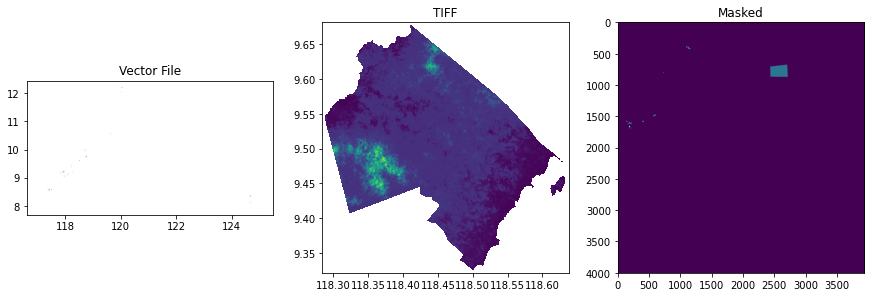

In [96]:
# export
# Generate masks for a file
masks, grids, values = generate_mask(
    tiff_file=tiff_file,
    shape_file=shape_file,
    output_file=target_file,
    labels_column="label",
    labels_dict=labels,
    plot=True,
)

In [97]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [98]:
grids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [99]:
values

{'mining': 1,
 'neg': 2,
 'agriculture': 3,
 'product_extraction': 4,
 'kaingin': 5,
 'biophysical': 6}